In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
#############################################
#############################################

df = pd.read_csv("breast_cancer_dataset.csv")

#############################################
#############################################

df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'skin', 'treatment', 'target'],
      dtype='object')

In [ ]:
#######################################################
#######################################################
y = df['target']
X = df.drop(columns=['target'])
#######################################################
#######################################################

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, shuffle=True
)

print("Shapes -> X_train:", X_train.shape, " | X_test:", X_test.shape)

Shapes -> X_train: (408, 32)  | X_test: (136, 32)


In [ ]:
#################################################################
cols_num = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension']
cols_cat = ['skin', 'treatment']
#################################################################

X_train_num = X_train[cols_num]
X_train_cat = X_train[cols_cat]
X_test_num = X_test[cols_num]
X_test_cat = X_test[cols_cat]

In [ ]:
X_train_cat

,skin,treatment
374,medium,sur
497,medium,qui
451,fair,sur
531,fair,sur
278,medium,qui
...,...,...
70,fair,sur
277,medium,qui
9,dark,qui
359,medium,qui


In [ ]:
########## codificado de columnas categoricas
# Nota este paso depende de EXPERIENCIA
####################################################################
cols_onehot  = ['skin']
cols_ordinal = ['treatment']

# Categorías ordenadas para las ordinales (mismo orden que en cols_ordinal)
categorias_ordinales = [['sur','qui']]# lista de listas
####################################################################

preprocessor_cat = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(sparse_output=False, drop=None, handle_unknown="ignore"), cols_onehot),
        ("ordinal", OrdinalEncoder(categories=categorias_ordinales, handle_unknown="use_encoded_value", unknown_value=-1), cols_ordinal),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

preprocessor_cat.fit(X_train_cat)

X_train_cat_proc = preprocessor_cat.transform(X_train_cat)
X_test_cat_proc = preprocessor_cat.transform(X_test_cat)

# -----------------------------------------
# Renombrar One-Hot a formato col___categoria
# -----------------------------------------
onehot = preprocessor_cat.named_transformers_.get("onehot")

rename_map = {}
if onehot is not None and len(cols_onehot) > 0:
    for col, cats in zip(cols_onehot, onehot.categories_):
        for cat in cats:
            old = f"{col}_{cat}"      # nombre que entrega sklearn con verbose_feature_names_out=False
            new = f"{col}___{cat}"    # triple guion bajo deseado
            rename_map[old] = new

# Obtener nombres del ColumnTransformer y aplicar renombres solo a OHE
cols_out_cat = preprocessor_cat.get_feature_names_out()
cols_out_cat = [rename_map.get(c, c) for c in cols_out_cat]

# Reconstruir DataFrames con índices originales
df_train_cat_encode = pd.DataFrame(X_train_cat_proc, columns=cols_out_cat, index=X_train_cat.index)
df_test_cat_encode  = pd.DataFrame(X_test_cat_proc,  columns=cols_out_cat, index=X_test_cat.index)
 

In [ ]:
###########################
########################### DIAGNÓSTICO DE COLUMNAS
###########################


# 1) Detecta numéricas
print("Columnas numéricas:", cols_num)

# 2) Funciones auxiliares
def iqr_outlier_stats(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0, 0.0, np.nan, np.nan, np.nan, np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lim_inf, lim_sup = q1 - 1.5*iqr, q3 + 1.5*iqr
    n_out = int(((s < lim_inf) | (s > lim_sup)).sum())
    prop_out = n_out / len(s)
    return n_out, prop_out, q1, q3, lim_inf, lim_sup

def bounded_guess(s: pd.Series):
    """Detecta si parece estar acotada en [0,1] o [0,100]."""
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return None
    mn, mx = float(s.min()), float(s.max())
    if 0.0 <= mn and mx <= 1.0:
        return "[0,1]"
    if 0.0 <= mn and mx <= 100.0:
        return "[0,100]"
    return None

if len(cols_num) == 0:
    print("No hay columnas numéricas en X_train. No se generan imágenes.")
else:
    # --------- Figura 1: HISTOGRAMAS (todos en subplots) ----------
    n = len(cols_num)
    ncols = min(3, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols_num):
        s = pd.to_numeric(X_train[col], errors="coerce").dropna()
        ax = axes[i]
        if s.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Frecuencia")
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.hist(s, bins=30)
            ax.set_title(col)
            ax.set_xlabel(col)
            ax.set_ylabel("Frecuencia")

    # Oculta subplots sobrantes
    for j in range(len(cols_num), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Histogramas de columnas numéricas", y=1.02, fontsize=12)
    fig.tight_layout()
    fig.savefig("histogramas_numericas.png", dpi=150, bbox_inches="tight")
    plt.close(fig)

    # --------- Figura 2: BOXPLOTS (todas en un eje) ----------
    series_pairs = []
    for c in cols_num:
        v = pd.to_numeric(X_train[c], errors="coerce").dropna().values
        if v.size > 0:
            series_pairs.append((c, v))

    if len(series_pairs) == 0:
        print("No hay datos numéricos válidos para boxplots. No se genera boxplot.")
        box_path = None
    else:
        labels = [c for c, _ in series_pairs]
        values = [v for _, v in series_pairs]

        fig2 = plt.figure(figsize=(1.6*len(labels)+4, 5))
        plt.boxplot(values, vert=True, showmeans=True)
        plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=35, ha="right")
        plt.ylabel("Valor")
        plt.title("Boxplots de columnas numéricas")
        plt.tight_layout()
        fig2.savefig("boxplots_numericas.png", dpi=150, bbox_inches="tight")
        plt.close(fig2)


# ================================
# Diagnóstico numérico + heurística
# ================================
diagnostico = []
for c in cols_num:
    s = pd.to_numeric(X_train[c], errors="coerce")
    miss_pct = s.isna().mean() * 100
    s_no_na = s.dropna()
    skew = s_no_na.skew() if s_no_na.size > 1 else np.nan
    kurt = s_no_na.kurt() if s_no_na.size > 1 else np.nan
    n_out, prop_out, q1, q3, li, ls = iqr_outlier_stats(s)
    bounds = bounded_guess(s)

    # Heurística de imputación
    if (prop_out >= 0.05) or (pd.notna(skew) and abs(skew) >= 1.0):
        imputador = "median"
    else:
        imputador = "mean"

    # Heurística de escalado
    if prop_out >= 0.05:
        escalador = "RobustScaler"
    elif pd.notna(skew) and abs(skew) <= 0.5:
        escalador = "StandardScaler"
    else:
        escalador = "MinMaxScaler"  # por defecto en casos no normales o acotados

    diagnostico.append({
        "columna": c,
        "missing_%": round(miss_pct, 2),
        "skew": round(skew, 3) if pd.notna(skew) else np.nan,
        "kurtosis": round(kurt, 3) if pd.notna(kurt) else np.nan,
        "outliers_n": n_out,
        "outliers_%": round(prop_out*100, 2),
        "q1": q1, "q3": q3, "IQR": (q3 - q1),
        "lim_inf": li, "lim_sup": ls,
        "bounded": bounds,
        "recom_imputer": imputador,
        "recom_scaler": escalador,
    })

diag_df = pd.DataFrame(diagnostico).sort_values(["outliers_%","missing_%"], ascending=False)
print("\n=== Diagnóstico numérico (heurística) ===\n")

##########################################################
##########################################################

# print(diag_df)

##########################################################
##########################################################

# Sugerencias de bloques numéricos (incluye median+Robust)
suggest_mean_rob = diag_df.query("recom_imputer=='mean' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_rob  = diag_df.query("recom_imputer=='median' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_min  = diag_df.query("recom_imputer=='median' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_med_std  = diag_df.query("recom_imputer=='median' and recom_scaler=='StandardScaler'")["columna"].tolist()
suggest_mean_min = diag_df.query("recom_imputer=='mean' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_mean_std = diag_df.query("recom_imputer=='mean' and recom_scaler=='StandardScaler'")["columna"].tolist()

print("\nSugerencias de bloques numéricos (auto):")
print("median+Robust   :", suggest_med_rob)
print("median+MinMax   :", suggest_med_min)
print("median+Standard :", suggest_med_std)
print("mean+Robust     :", suggest_mean_rob)
print("mean+MinMax     :", suggest_mean_min)
print("mean+Standard   :", suggest_mean_std)

Columnas numéricas: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

=== Diagnóstico numérico (heurística) ===


Sugerencias de bloques numéricos (auto):
median+Robust   : ['area error', 'worst area', 'radius error', 'mean area', 'perimeter error', 'fractal dimension error', 'smoothness error', 'symmetry error', 'concavity error', 'worst compactness']
median+MinMax   : ['compactness error', 'worst radius', 'texture error', 'concave points error', 'worst perimeter', 'm

In [ ]:
# --- Listas de columnas ---
# Nota este paso depende de EXPERIENCIA
# Numéricas
# num_med_rob_cols: inputacion mediana con escalado robusto
# num_med_min_cols: inputación mediana con escalado min_max
# num_med_std_cols: inputacion mediana con escalado Estandar
# num_mean_rob_cols: inputación media con escalado robusto
# num_mean_min_cols: inputacion media con escalado min_max
# num_mean_std_cols: inputacion media con escalado Estandar

#########################################################
#########################################################

num_med_rob_cols = ['area error', 'worst area', 'radius error', 'mean area', 'perimeter error', 'fractal dimension error', 'smoothness error', 'symmetry error', 'concavity error', 'worst compactness']   # mediana + Robust
num_med_min_cols = ['compactness error', 'worst radius', 'texture error', 'concave points error', 'worst perimeter', 'mean concave points', 'worst fractal dimension', 'mean concavity', 'worst symmetry', 'mean radius', 'mean compactness', 'mean fractal dimension', 'mean perimeter', 'worst concavity']   # mediana + MinMax
#num_med_std_cols = []   # mediana + Estandar
#num_mean_rob_cols = []   # media + Robust
num_mean_min_cols  = ['mean symmetry', 'mean smoothness', 'worst smoothness', 'mean texture', 'worst texture', 'worst concave points']    # media + MinMax
#num_mean_std_cols  = []
 

In [ ]:
# --- Pipelines NUMÉRICOS ---
pipe_med_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  RobustScaler())
])
 
pipe_med_min = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  MinMaxScaler())
])
 
'''pipe_med_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])'''
 
 
'''pipe_mean_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  RobustScaler())
])'''
 
pipe_mean_min = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  MinMaxScaler())
])
 
'''pipe_mean_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])'''

'pipe_mean_std = Pipeline([\n    ("imputer", SimpleImputer(strategy="mean")),\n    ("scaler",  StandardScaler())\n])'

In [ ]:
# --- ColumnTransformer unificado ---
preprocessor_num = ColumnTransformer(
    transformers=[
        ("num_med_rob", pipe_med_rob, num_med_rob_cols),
        ("num_med_min", pipe_med_min, num_med_min_cols),
        #("num_med_std", pipe_med_std, num_med_std_cols),
        #("num_mean_rob",  pipe_mean_rob,  num_mean_rob_cols),
        ("num_mean_min",  pipe_mean_min,  num_mean_min_cols),
        #("num_mean_std",  pipe_mean_std,  num_mean_std_cols),
 
        # Passthrough (sin preprocesar)
        #("passthrough",  "passthrough", passthrough_cols),
 
        # Drop explícito
        #("drop_high_na", "drop",        drop_cols),
    ],
    remainder="drop",                        # descarta cualquier otra columna no listada
    verbose_feature_names_out=False
)

In [ ]:
from sklearn.decomposition import PCA

# Pipeline para estimar TODO el espectro (sin producir T todavía)
pca_pipe_full = Pipeline(steps=[
    ("pre", preprocessor_num),           # tu preprocesador tal cual
    ("std_for_pca", StandardScaler()),   # re-estandarización para correlaciones
    ("pca", PCA(n_components=None, svd_solver="full", random_state=0)),
])

# FIT solo con train (no hacemos transform)
pca_pipe_full.fit(X_train_num)

,steps,"[('pre', ...), ('std_for_pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_med_rob', ...), ('num_med_min', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [ ]:
# Espectro
pca_full = pca_pipe_full.named_steps["pca"]
expl = pca_full.explained_variance_ratio_
cum  = np.cumsum(expl)
ks   = np.arange(1, len(expl)+1)
 
# Sugerencias de k
k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)
# “Codo” simple por segunda diferencia
d2 = np.diff(np.diff(expl))
k_elbow = int(np.argmax(-d2) + 2) if len(d2) else 1
 
print("Varianza explicada (primeros 10):", np.round(expl[:10], 6))
print("Acumulada (primeros 10):         ", np.round(cum[:10], 6))
print(f"Sugerencias -> k@90%={k90}, k@95%={k95}, k(elbow)={k_elbow}")

Varianza explicada (primeros 10): [0.438581 0.192613 0.095757 0.06619  0.058433 0.038848 0.021102 0.016085
 0.014378 0.011422]
Acumulada (primeros 10):          [0.438581 0.631194 0.726952 0.793142 0.851575 0.890423 0.911525 0.92761
 0.941988 0.95341 ]
Sugerencias -> k@90%=7, k@95%=10, k(elbow)=5


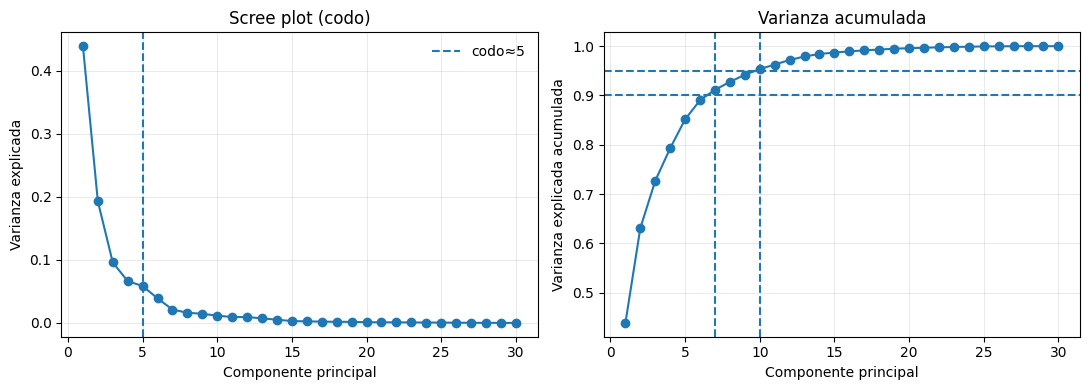

In [ ]:
# --------- Gráficos ----------
fig, axs = plt.subplots(1, 2, figsize=(11, 4))
 
# (a) Scree / codo
axs[0].plot(ks, expl, marker="o")
axs[0].set_xlabel("Componente principal")
axs[0].set_ylabel("Varianza explicada")
axs[0].set_title("Scree plot (codo)")
axs[0].grid(True, linewidth=0.4, alpha=0.5)
axs[0].axvline(k_elbow, linestyle="--", label=f"codo≈{k_elbow}")
axs[0].legend(frameon=False)
 
# (b) Acumulada con líneas de referencia
axs[1].plot(ks, cum, marker="o")
axs[1].set_xlabel("Componente principal")
axs[1].set_ylabel("Varianza explicada acumulada")
axs[1].set_title("Varianza acumulada")
axs[1].grid(True, linewidth=0.4, alpha=0.5)
axs[1].axhline(0.90, linestyle="--"); axs[1].axvline(k90, linestyle="--")
axs[1].axhline(0.95, linestyle="--"); axs[1].axvline(k95, linestyle="--")
 
plt.tight_layout(); plt.show()

In [ ]:
# Elige el número de componentes (puedes usar 0.95 para varianza acumulada)
 
###############################################
k = k_elbow
###############################################
 
pca_pipe = Pipeline(steps=[
    ("pre", preprocessor_num),         # tu preprocesador tal cual
    ("std_for_pca", StandardScaler()), # re-estandarización para usar correlaciones
    ("pca", PCA(n_components=k, svd_solver="full", random_state=0)),
 
])
 
# --- FIT en train ---
pca_pipe.fit(X_train_num)
 
# --- TRANSFORM en train y test ---
T_train = pca_pipe.transform(X_train_num)
T_test  = pca_pipe.transform(X_test_num)
 
# DataFrames de scores
pc_cols = [f"PC{i+1}" for i in range(T_train.shape[1])]
T_train_df = pd.DataFrame(T_train, columns=pc_cols, index=X_train_num.index)
T_test_df  = pd.DataFrame(T_test,  columns=pc_cols, index=X_test_num.index)
 
# Varianza explicada
pca_step = pca_pipe.named_steps["pca"]
expl = pca_step.explained_variance_ratio_
print("Varianza explicada:", np.round(expl, 6))
print("Acumulada:", np.round(np.cumsum(expl), 6))
 
# Guardar outputs (opcional)
T_train_df.to_csv("T_train_PCA.csv", index=False)
T_test_df.to_csv("T_test_PCA.csv", index=False)
 
print("Shapes -> T_train:", T_train_df.shape, "| T_test:", T_test_df.shape)
display(T_train_df.head())

Varianza explicada: [0.438581 0.192613 0.095757 0.06619  0.058433]
Acumulada: [0.438581 0.631194 0.726952 0.793142 0.851575]
Shapes -> T_train: (408, 5) | T_test: (136, 5)


,PC1,PC2,PC3,PC4,PC5
374,-2.263434,2.629782,1.318733,-1.495010,3.558768
497,3.900765,-3.697866,1.903668,2.351680,-0.004161
451,1.064643,0.990105,-2.273339,0.360295,0.655516
531,-3.255724,-0.785387,-0.843817,-1.612741,0.178498
278,3.400299,-3.985039,-0.398154,1.909369,-1.289693


In [ ]:
# Solo si k >= 2
import plotly.express as px
 
df_plot2 = T_train_df.iloc[:, :2].copy()
df_plot2["objetivo"] = y_train.loc[T_train_df.index].astype(str)
fig2 = px.scatter(df_plot2, x="PC1", y="PC2", color="objetivo",
                  opacity=0.85, title="PC1 vs PC2 por 'objetivo' (train)", height=550)
fig2.update_traces(marker=dict(size=6))
fig2.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig2.show()

In [ ]:
#### Solo si k>=3
df_plot = T_train_df.iloc[:, :3].copy()          # PC1, PC2, PC3
# Alinea objetivo con los índices de T_train_df
df_plot["objetivo"] = y_train.loc[T_train_df.index].astype(str)
 
fig = px.scatter_3d(
    df_plot,
    x="PC1", y="PC2", z="PC3",
    color="objetivo",
    opacity=0.85,
    title="PC1–PC2–PC3 por ‘objetivo’ (train)",
    height=600
)
fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3"))
fig.show()

In [ ]:
# === Concatenar PCs (numéricas) con categóricas codificadas ===
# Asegura alineación por índice
df_train_cat_encode = df_train_cat_encode.reindex(T_train_df.index)
df_test_cat_encode  = df_test_cat_encode.reindex(T_test_df.index)
 
T_train_final = pd.concat([T_train_df, df_train_cat_encode], axis=1)
T_test_final  = pd.concat([T_test_df,  df_test_cat_encode], axis=1)
 
# Añadir columna objetivo (alineada por índice)
T_train_final_out = T_train_final.copy()
T_test_final_out  = T_test_final.copy()
 
T_train_final_out["objetivo"] = y_train.loc[T_train_final.index].astype(str)
T_test_final_out["objetivo"]  = y_test.loc[T_test_final.index].astype(str)
 
 
print("T_train_final:", T_train_final.shape)
print("T_test_final :", T_test_final.shape)
 
T_train_final.to_csv("T_train_final.csv", index=False)
T_test_final.to_csv("T_test_final.csv", index=False)
T_train_final_out.to_csv("T_train_final_objetivo.csv", index=False)
T_test_final_out.to_csv("T_test_final_objetivo.csv", index=False)
# X_train_final.head()

T_train_final: (408, 9)
T_test_final : (136, 9)


In [ ]:
T_train_final_out

,PC1,PC2,PC3,PC4,PC5,skin___dark,skin___fair,skin___medium,treatment,objetivo
374,-2.263434,2.629782,1.318733,-1.495010,3.558768,0.0,0.0,1.0,0.0,1
497,3.900765,-3.697866,1.903668,2.351680,-0.004161,0.0,0.0,1.0,1.0,0
451,1.064643,0.990105,-2.273339,0.360295,0.655516,0.0,1.0,0.0,0.0,0
531,-3.255724,-0.785387,-0.843817,-1.612741,0.178498,0.0,1.0,0.0,0.0,1
278,3.400299,-3.985039,-0.398154,1.909369,-1.289693,0.0,0.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
70,-1.710903,0.418392,-1.240932,-1.222253,0.124592,0.0,1.0,0.0,0.0,1
277,-1.801932,1.616725,-0.007601,-1.593859,-2.245381,0.0,0.0,1.0,1.0,1
9,-1.086461,0.975455,-0.650625,-0.868587,1.518172,1.0,0.0,0.0,1.0,1
359,-1.171817,0.530888,-2.251999,-1.601197,0.418444,0.0,0.0,1.0,1.0,1


In [ ]:
# === Guardar artefactos ===
import joblib
import json
 
# 1) Pipelines ya FIT: preprocessor_cat y pca_pipe
joblib.dump(preprocessor_cat, "preprocessor_cat.joblib")
joblib.dump(pca_pipe, "pca_pipe_num.joblib")   # (preprocessor_num + StdScaler + PCA)
 
# 2) Metadatos útiles para producción
meta = {
    "cols_num": cols_num,            # columnas numéricas originales
    "cols_cat": cols_cat,            # columnas categóricas originales
    "pc_cols": list(T_train_df.columns),            # nombres de PCs (PC1, PC2, …)
    "cat_out_cols": list(df_train_cat_encode.columns)  # columnas codificadas finales (OHE + Ordinal)
}
with open("pca_metadata.json", "w") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)